In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = 'images'
data_dir = pathlib.Path(data_dir)
photos = list(data_dir.glob('photo/*'))
schemas = list(data_dir.glob('schema/*'))

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Found 28 files belonging to 2 classes.
Using 23 files for training.
Found 28 files belonging to 2 classes.
Using 5 files for validation.
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6995 - accuracy: 0.5217 - val_loss: 0.6001 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 1s 574ms/step - loss: 0.4920 - accuracy: 0.9130 - val_loss: 6.1782 - val_accuracy: 0.4000
Epoch 3/10
1/1 [==============================] - 1s 600ms/step - loss: 4.7767 - accuracy: 0.5217 - val_loss: 1.6177 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 1s 586ms/step - loss: 1.4955 - accuracy: 0.4783 - val_loss: 0.6597 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 1s 562ms/step - loss: 0.4670 - accuracy: 0.6957 - val_loss: 0.6419 - val_accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 1s 523ms/step - loss: 0.4584 - accuracy: 0.7391 - val_loss: 0.5960 - val_accuracy: 0.8000
Epoch 7/10
1/1 [==========

1/1 [==============================] - 0s 55ms/step
This image most likely belongs to photo with a 64.68 percent confidence.


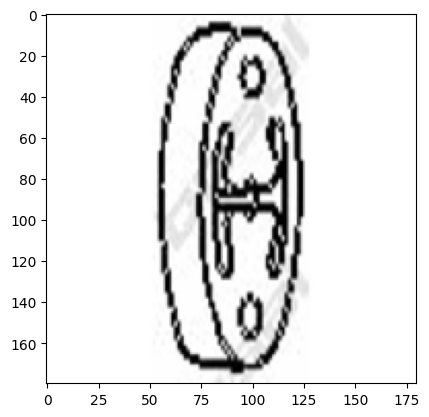

In [3]:
# Przewiduj nowe dane
test_photo_url = "https://t.iparts.pl/041/255215/dokumenty/wieszak-ukladu-wydechowego-bosal.jpg"
test_photo_path = tf.keras.utils.get_file("file_name2", origin=test_photo_url)

img = tf.keras.utils.load_img(
    test_photo_path, target_size=(img_height, img_width)
)
plt.imshow(img)  
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)